### Import packages

In [1]:
import os
import json
import numpy as np
from time import time
import tensorflow as tf
import cv2
from cv2 import filter2D
import matplotlib.pyplot as plt
from collections import defaultdict
import lucid.optvis.render as render
from keras.preprocessing import image
from tensorflow.python.platform import gfile
import lucid.modelzoo.vision_models as models
from tensorflow.python.framework import tensor_util
from keras.applications.inception_v3 import preprocess_input

ModuleNotFoundError: No module named 'cv2'

### Restore Inception_v1 model

In [2]:
def load_model_from_file(pb_file_path):
    '''
    Load tensorflow model from .pb file
    * input
        - pb_file_path: .pb file path (string)
    * output
        - graph_nodes: nodes in the loaded model (tensorflow nodes)
    '''
    with tf.Session() as sess:
        # Get graphdef from the pb file
        with gfile.GFile(pb_file_path, 'rb') as f:
            graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

        # Get nodes in the graph
        sess.graph.as_default()
        tf.import_graph_def(graph_def, name='')
        graph_nodes = graph_def.node
        
    return graph_nodes

def get_weight_nodes(graph_nodes):
    '''
    Get only filter nodes from all nodes in the graph
    * input
        - graph_nodes: nodes in the loaded model (tensorflow nodes)
    * output
        - weight_nodes: filter nodes (list of tensorflow nodes)
        - names: name of the filters (list of the filter nodes)
    '''
    weight_nodes = [n for n in graph_nodes if n.op == 'Const']
    names = [n.name for n in weight_nodes]
    return weight_nodes, names


def get_layers(filter_names):
    '''
    Get all layers
    * input
        - filter_names: name of the filters (list of the filter nodes)
    * output
        - layers: list of all layers
    '''
    layers = []
    for n in filter_names:
        if n[-2:] == '_w':
            layer = n.split('_')[0]
            if layer not in layers:
                layers.append(layer)
    return layers


def get_prev_layer(layers, layer):
    '''
    Get previous layer
    * input
        - layers: list of all layers
        - layer: the name of a layer
    * output
        - prev_layer: the name of a previuos layer
    '''
    prev_layer = layers[layers.index(layer) - 1]
    return prev_layer


def get_weight(layer, weight_nodes):
    '''
    Get all weight values between the given layer and the previous layer
    * input
        - layer: the name of layer
        - weight_nodes: filter nodes (list of tensorflow nodes)
    * output
        - ws: a dictionary, where
            - key: the name of the weight
            - value: the weight values
    '''
    
    nodes_of_layer = [n for n in weight_nodes if (layer in n.name) and (n.name[-2:] == '_w')]
    ws = {n.name: tf_node_to_nparr(n) for n in nodes_of_layer}
    
    return ws


def tf_node_to_nparr(t):
    '''
    Convert tensorflow node to numpy array
    * input
        - t: a tensorflow node
    * output
        - arr: converted numpy array
    '''
    arr = tensor_util.MakeNdarray(t.attr['value'].tensor)
    return arr


def get_shape_of_node(n):
    '''
    Get the shape of the tensorflow node
    * input
        - n: tensorflow node
    * output
        - tensor_shape: shape of n
    '''
    dims = n.attr['value'].tensor.tensor_shape.dim
    tensor_shape = [d.size for d in dims]
    return tensor_shape


def get_channel_sizes(layer, weight_nodes):
    '''
    Get channel sizes
    * input
        - layer: the name of layer
        - weight_nodes: tensorflow nodes for all filters
    * output
        - channel_sizes: list of channel size for all pre-concatenated blocks
    '''
    
    channel_sizes = [get_shape_of_node(n)[0] for n in weight_nodes if layer in n.name and '_b' == n.name[-2:] and 'bottleneck' not in n.name]
    return channel_sizes


def get_num_channel(layer, weight_nodes):
    '''
    Get the number of channels in the layer
    * input
        - layer: the name of layer (e.g. 'mixed5a' for normal layer, 'mixed5a_1' for 1st branch after mixed_5a layer)
        - is_branch: whether the layer is in a branch
    * output
        - num_channel: the number of channel
    '''
    
    is_branch = '_' in layer
    
    if is_branch:
        layer_name = layer[:-2]
        branch = int(layer[-1])
        branch_weights = [n for n in weight_nodes if layer_name in n.name and 'bottleneck_w' in n.name]
        branch_weight = branch_weights[branch - 1]
        num_channel = get_shape_of_node(branch_weight)[-1]
        return num_channel
    
    else:
        num_channel = np.sum(get_channel_sizes(layer, weight_nodes))
        return num_channel


def get_weight_sizes(nodes, all_layers):
    
    weight_sizes = {}
    for n in nodes:
        if '_w' in n.name and 'mixed' in n.name:
            layer = n.name.split('_')[0]
            if layer in all_layers:
                if layer not in weight_sizes:
                    weight_sizes[layer] = {}
                weight_sizes[layer][n.name] = get_shape_of_node(n)

    return weight_sizes


def get_act_sizes(weight_sizes, mixed_layers):
    act_sizes = {}
    for layer in mixed_layers:
        act_sizes[layer] = []
        for f_tile in ['1x1', '3x3', '5x5']:
            a_size = weight_sizes[layer]['{}_{}_w'.format(layer, f_tile)][2]
            act_sizes[layer].append(a_size)
    return act_sizes


def get_act_maps(model, layer, input_img):
    '''
    Get activation maps
    * input
        - model: tensorflow model (..maybe?, modelzoo model in this case)
        - layer: name of the layer
        - input_img: input image (numpy array)
    * output
        - acts: activation maps of the layer for the input image (numpy array)
    '''

    # Make sure the reshaped_input_img has a shape of (1, 224, 224, 3)
    reshaped_input_img = input_img if input_img.ndim == 4 else input_img.reshape(-1, 224, 224, 3)
    
    # Run the model and get the activation map
    with tf.Graph().as_default(), tf.Session():
        tf_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
        T = render.import_model(model, tf_input, tf_input)
        acts = T(layer).eval({tf_input: reshaped_input_img})
    
    return acts

### Import image 

In [3]:
def load_image(filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    return img

In [4]:
def resize_image(filepath):
    img = cv2.imread(filepath)
    h, w = img.shape[0], img.shape[1]
    sz = min(h, w)
    resized_image = image.load_img(filepath, target_size=(sz, sz))
    return resized_image

### Influence info

In [5]:
def get_branch(layer, channel, layer_channels):
    '''
    Get branch of the channel in the layer
    * input
        - layer: the name of layer
        - channel: channel in the layer
        - layer_channels: fragment sizes of the layer
    * output
        - branch: branch of the channel
    '''
    
    channels = layer_channels[:]
    for i in range(len(channels) - 1):
        channels[i + 1] += channels[i]
        
    branch = np.searchsorted(channels, channel, side='right')
    
    return branch


def update_inner_info_a_channel(input_acts, filters, channel, I_layer, O_layer):
    num_prev_channel = input_acts.shape[-1]

    for prev_channel in range(num_prev_channel):
        F = filters[:, :, prev_channel]
        conv_out = filter2D(input_acts[0, :, :, prev_channel], -1, F)
        max_val = np.max(conv_out)
        
        if prev_channel not in I_layer[channel]:
            I_layer[channel][prev_channel] = []
            O_layer[channel][prev_channel] = []
            
        I_layer[channel][prev_channel].append(max_val)
        O_layer[channel][prev_channel].append(conv_out)
        
        
def update_inner_info_all_channels(w, start_c, end_c, I_layer, O_layer, input_acts):
    for channel in range(start_c, end_c):
        filters = w[:, :, :, channel - start_c]
        update_inner_info_a_channel(input_acts, filters, channel, I_layer, O_layer)

### Initialization

In [6]:
def init_inf_out_dict(layer, weight_nodes):
    
    # Initialize I_layer, O_layer
    num_channel = get_num_channel(layer, weight_nodes)
    
    I_layer = {c: {} for c in range(num_channel)}
    O_layer = {c: {} for c in range(num_channel)}
    
    return I_layer, O_layer

### Set filepathes

In [7]:
json_dirpath = '/Users/haekyu/data/summit/I-matrices'

### Load inception model

In [8]:
GRAPH_PB_PATH = 'gs://modelzoo/vision/other_models/InceptionV1.pb'
graph_nodes = load_model_from_file(GRAPH_PB_PATH)

weight_nodes, names = get_weight_nodes(graph_nodes)
all_layers = get_layers(names)
target_layers = [layer for layer in all_layers if 'mixed' in layer]

googlenet = models.InceptionV1()
googlenet.load_graphdef()
nodes = googlenet.graph_def.node

### Get size info

In [9]:
layer_fragment_sizes = {layer: get_channel_sizes(layer, nodes) for layer in target_layers}
weight_sizes = get_weight_sizes(nodes, all_layers)
act_sizes = get_act_sizes(weight_sizes, target_layers)

### Get M matrices info

In [10]:
with open('./imagenet.json', 'r') as f:
    data = json.load(f)

In [11]:
M_class = {}
for d in data:
    M_class[int(d['target_class'])] = d

In [12]:
M_class[270]['name']

'white_wolf'

In [13]:
# for i, d in enumerate(data):
#     if (d['name'] == 'ambulance'):
#         print(i, d['target_class'])
M_class[407]['name']

'ambulance'

In [14]:
for i, d in enumerate(data):
    if ('polaroid_camera' in d['name']):
        print(i, d['target_class'])
M_class[732]['name']

856 732


'polaroid_camera'

In [15]:
for i, d in enumerate(data):
    if ('tiger' == d['name']):
        print(i, d['target_class'])
M_class[292]['name']

75 292


'tiger'

In [16]:
for i, d in enumerate(data):
    if ('egyptian_cat' in d['name']):
        print(i, d['target_class'])
M_class[285]['name']

7 285


'egyptian_cat'

In [18]:
for i, d in enumerate(data):
    if ('mountain_tent' in d['name']):
        print(i, d['target_class'])
M_class[672]['name']

727 672


'mountain_tent'

In [21]:
for i, d in enumerate(data):
    if ('shore' in d['name']):
        print(i, d['target_class'])
M_class[978]['name']

366 978


'seashore'

### Read input image

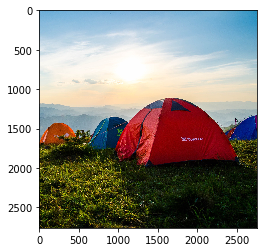

In [79]:
dirname = './outlier'

# White wolf
# dirname = './wolf_all'
# pred_class = 270
# class_name = 'white_wolf'

# Macaw
# pred_class = 88
# class_name = 'macaw'

# Seashore
# pred_class = 978
# class_name = 'seashore'

# Egyptian cat
# pred_class = 285
# class_name = 'egyptian_cat'

# Mountain tent
pred_class = 672
class_name = 'mountain_tent'

# Polaroid camera
# pred_class = 732
# class_name = 'polaroid_camera'

# Tiger
# pred_class = 292
# class_name = 'tiger'

# African elephant
# dirname = './image2'
# pred_class = 386
# class_name = 'elephant'

# Tench
# dirname = './tench'
# pred_class = 0
# class_name = 'tench'

# Ambulance
# dirname = './ambulance'
# pred_class = 407
# class_name = 'ambulance'

imgth = 7
img_lst = os.listdir(dirname)
img_files = [dirname + '/' + n for n in img_lst if ('jpg' in str.lower(n)) or ('jpeg' in str.lower(n))]
input_images = [load_image(img_file) for img_file in img_files]
input_image = input_images[imgth]
ori_images = [resize_image(img_file) for img_file in img_files]
ori_image = ori_images[imgth]

# plt.figure()
# plt.imshow(input_image)
# plt.show()

plt.figure()
plt.imshow(ori_image)
plt.show()

### Run and get max activation and conv output

In [80]:
I_layers = {}
O_layers = {}

tic = time()
# for layer in target_layers:
for layer in ['mixed3a', 'mixed3b']:
    
    # Get weights
    ws = get_weight(layer, weight_nodes)

    # Initialize I_layer, O_layer
    I_layer, O_layer = init_inf_out_dict(layer, weight_nodes)
    
    # Initialize I_layer_1, O_layer_1
    I_layer_1, O_layer_1 = init_inf_out_dict(layer + '_1', weight_nodes)
    
    # Initialize I_layer_2, O_layer_2
    I_layer_2, O_layer_2 = init_inf_out_dict(layer + '_2', weight_nodes)

    # Get input_acts
    prev_layer = get_prev_layer(all_layers, layer)
    input_acts = get_act_maps(googlenet, prev_layer, input_image)
    
    # Get branch_1_acts
    branch_1_acts = get_act_maps(googlenet, layer + '_3x3_bottleneck', input_image)
    
    # Get branch_2_acts
    branch_2_acts = get_act_maps(googlenet, layer + '_5x5_bottleneck', input_image)
    
    # Get accumulated fragment sizes
    frag_szs = layer_fragment_sizes[layer]
    channels = frag_szs[:]
    for i in range(len(channels) - 1):
        channels[i + 1] += channels[i]
    
    # Update I_layer, fragment 0
    w = ws['%s_1x1_w' % layer]
    update_inner_info_all_channels(w, 0, channels[0], I_layer, O_layer, input_acts)
    
    # Update I_layer, fragment 1
    w = ws['%s_3x3_w' % layer]
    update_inner_info_all_channels(w, channels[0], channels[1], I_layer, O_layer, branch_1_acts)
    
    # Update I_layer, fragment 2
    w = ws['%s_5x5_w' % layer]
    update_inner_info_all_channels(w, channels[1], channels[2], I_layer, O_layer, branch_2_acts)

    # Update I_layer, fragment 3
    w = ws['%s_pool_reduce_w' % layer]
    update_inner_info_all_channels(w, channels[2], channels[3], I_layer, O_layer, input_acts)
        
    # Update I_layer_branch1, fragment 4
    branch = 1
    w = ws['%s_3x3_bottleneck_w' % layer]
    num_channels = act_sizes[layer][branch]
    update_inner_info_all_channels(w, 0, num_channels, I_layer_1, O_layer_1, input_acts)
        
    # Update I_layer_branch1, fragment 5
    branch = 2
    w = ws['%s_5x5_bottleneck_w' % layer]
    num_channels = act_sizes[layer][branch]
    update_inner_info_all_channels(w, 0, num_channels, I_layer_2, O_layer_2, input_acts)
    
    toc = time()
    print('{}: {} sec'.format(layer, round(toc - tic, 2)))
    tic = toc
        
    I_layers[layer] = I_layer
    I_layers[layer + '_1'] = I_layer_1
    I_layers[layer + '_2'] = I_layer_2
    O_layers[layer] = O_layer
    O_layers[layer + '_1'] = O_layer_1
    O_layers[layer + '_2'] = O_layer_2

mixed3a: 2.28 sec
mixed3b: 2.96 sec


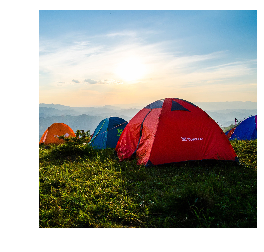

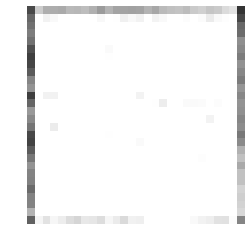

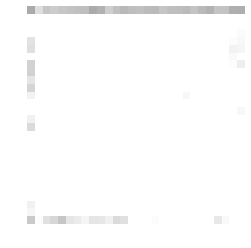

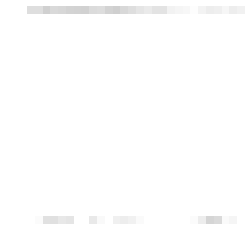

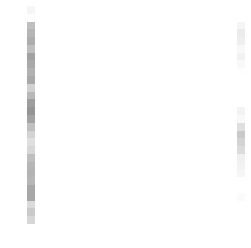

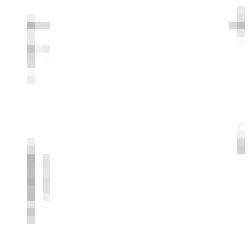

In [89]:
vmin, vmax = 100, -100

# Show Input figure
plt.figure()
plt.imshow(ori_image)
plt.axis('off')
# plt.savefig('/Users/haekyu/Desktop/outliers/{}.pdf'.format(class_name))
plt.show()

outliers = ['mixed3a-67', 'mixed3a-190', 'mixed3b-390', 'mixed3b-399', 'mixed3b-412']
for outlier in outliers:
    layer, neuron = outlier.split('-')
    neuron = int(neuron)

    # Get vmin and vmax
    for prev in O_layers[layer][neuron]:
        int_act = O_layers[layer][neuron][prev][0]
        vmin = min(vmin, np.min(int_act))
        vmax = max(vmax, np.max(int_act))
    
    # Get activation of the neuron
    total_act = np.zeros((28, 28))
    for prev in O_layers[layer][neuron]:
        int_act = O_layers[layer][neuron][prev][0]
        total_act += int_act

    # Show activation
    plt.figure()
    plt.imshow(vmax - total_act, vmin=vmin, vmax=vmax * 1.1, cmap='gray')
    # cbar = plt.colorbar(orientation='horizontal')
    # cbar.ax.tick_params(labelsize=15)
    plt.axis('off')
    plt.savefig('/Users/haekyu/Desktop/outliers/{}-{}-{}.svg'.format(class_name, layer, neuron))
    plt.show()

### Do test example

In [40]:
# # Wolf, face
# layer = 'mixed4c'
# channel = 264

# # African elephant
# layer = 'mixed5a'
# channel = 386

# Tench
# layer = 'mixed4e'
# channel = 346

In [36]:
# # Get top maximum prev channels
# prev_max_dict = I_layers[layer][channel]
# sorted_prevs = sorted(prev_max_dict, key=prev_max_dict.get, reverse=True)

# # Get branch
# branch = get_branch(layer, channel, layer_fragment_sizes[layer])
# if branch in [1, 2]:
#     prev = '{}_{}'.format(layer, branch)
# else:
#     prev = get_prev_layer(all_layers, layer)

# print('top 5 previous neurons (in {}): {}'.format(prev, sorted_prevs[:5]))
# print('-' * 60)

# # Get top previous neuron's top previous neurons
# prev_channel = sorted_prevs[0]
# prev_prev_max_dict = I_layers[prev][prev_channel]
# sorted_prev_prevs = sorted(prev_prev_max_dict, key=prev_prev_max_dict.get, reverse=True)
# print('top 5 prev prev neurons:', sorted_prev_prevs[:5])

# # output
# for prev_prev in sorted_prev_prevs[:5]:
#     out_conv = O_layers[prev][prev_channel][prev_prev]
#     plt.figure()
#     plt.imshow(out_conv)
#     plt.colorbar()
#     plt.title(prev_prev)
#     plt.show()


In [34]:
# layer_fragment_sizes

In [35]:
# act_sizes

### Test exmaples for all images

In [33]:
# I_layers = {}
# O_layers = {}
# weights = {}

# for layer in target_layers:
    
#     # Get prev_channel
#     prev_layer = get_prev_layer(all_layers, layer)
    
#     # Initialize I_layer, O_layer
#     I_layer, O_layer = init_inf_out_dict(layer, weight_nodes)

#     # Initialize I_layer_1, O_layer_1
#     I_layer_1, O_layer_1 = init_inf_out_dict(layer + '_1', weight_nodes)

#     # Initialize I_layer_2, O_layer_2
#     I_layer_2, O_layer_2 = init_inf_out_dict(layer + '_2', weight_nodes)
    
#     # Get weights
#     ws = get_weight(layer, weight_nodes)

#     # Save I, O, W
#     I_layers[layer] = I_layer
#     I_layers[layer + '_1'] = I_layer_1
#     I_layers[layer + '_2'] = I_layer_2
#     O_layers[layer] = O_layer
#     O_layers[layer + '_1'] = O_layer_1
#     O_layers[layer + '_2'] = O_layer_2
#     weights[layer] = ws   

In [32]:
# img_lst = os.listdir(dirname)
# img_files = [dirname + '/' + n for n in img_lst if 'jpeg' in str.lower(n)]
# input_images = [load_image(img_file) for img_file in img_files]

# for input_image in input_images:
    
# #     plt.figure()
# #     plt.imshow(input_image)
# #     plt.show()

#     for layer in target_layers:
        
#         if layer != 'mixed4e':
#             continue
            
#         tic = time()
        
#         # Get input_acts
#         prev_layer = get_prev_layer(all_layers, layer)
#         input_acts = get_act_maps(googlenet, prev_layer, input_image)

#         # Get branch_1_acts
#         branch_1_acts = get_act_maps(googlenet, layer + '_3x3_bottleneck', input_image)

#         # Get branch_2_acts
#         branch_2_acts = get_act_maps(googlenet, layer + '_5x5_bottleneck', input_image)

#         # Get accumulated fragment sizes
#         frag_szs = layer_fragment_sizes[layer]
#         channels = frag_szs[:]
#         for i in range(len(channels) - 1):
#             channels[i + 1] += channels[i]
            
#         # Get weights
#         ws = weights[layer]

#         # Update I_layer, fragment 0
#         w = ws['%s_1x1_w' % layer]
#         update_inner_info_all_channels(w, 0, channels[0], I_layers[layer], O_layers[layer], input_acts)

#         # Update I_layer, fragment 1
#         w = ws['%s_3x3_w' % layer]
#         update_inner_info_all_channels(w, channels[0], channels[1], I_layers[layer], O_layers[layer], branch_1_acts)

#         # Update I_layer, fragment 2
#         w = ws['%s_5x5_w' % layer]
#         update_inner_info_all_channels(w, channels[1], channels[2], I_layers[layer], O_layers[layer], branch_2_acts)

#         # Update I_layer, fragment 3
#         w = ws['%s_pool_reduce_w' % layer]
#         update_inner_info_all_channels(w, channels[2], channels[3], I_layers[layer], O_layers[layer], input_acts)

#         # Update I_layer_branch1, fragment 4
#         branch = 1
#         w = ws['%s_3x3_bottleneck_w' % layer]
#         num_channels = act_sizes[layer][branch]
#         update_inner_info_all_channels(w, 0, num_channels, I_layers[layer + '_1'], O_layers[layer + '_1'], input_acts)

#         # Update I_layer_branch1, fragment 5
#         branch = 2
#         w = ws['%s_5x5_bottleneck_w' % layer]
#         num_channels = act_sizes[layer][branch]
#         update_inner_info_all_channels(w, 0, num_channels, I_layers[layer + '_2'], O_layers[layer + '_2'], input_acts)

#         toc = time()
#         print('{}: {} sec'.format(layer, round(toc - tic, 2)))
        

In [31]:
# I_mixed4e_346 = {}
# for channel in I_layers['mixed4e'][346]:
#     avg = np.average(I_layers['mixed4e'][346][channel])
#     I_mixed4e_346[channel] = avg
    
# I_mixed4e_715 = {}
# for channel in I_layers['mixed4e'][715]:
#     avg = np.average(I_layers['mixed4e'][715][channel])
#     I_mixed4e_715[channel] = avg

In [30]:
# top_prevs_346 = sorted(I_mixed4e_346, key=I_mixed4e_346.get, reverse=True)[:10]
# for top_prev in top_prevs_346:
#     print(top_prev, I_mixed4e_346[top_prev], I_layers['mixed4e'][346][top_prev])
    
# print('----')

# top_prevs_715 = sorted(I_mixed4e_715, key=I_mixed4e_715.get, reverse=True)[:10]
# for top_prev in top_prevs_715:
#     print(top_prev, I_mixed4e_715[top_prev], I_layers['mixed4e'][715][top_prev])

In [29]:
# layer_fragment_sizes['mixed4e']

In [28]:
# I_mixed4e_1_346 = {}
# for top_prev in top_prevs_346:
#     I_mixed4e_1_346[top_prev] = {}
#     for prev_prev in I_layers['mixed4e_1'][top_prev]:
#         I_mixed4e_1_346[top_prev][prev_prev] = np.average(I_layers['mixed4e_1'][top_prev][prev_prev])

In [27]:
# top_prev_prevs_346 = defaultdict(lambda: 0)
# for top_prev_346 in top_prevs_346:
#     top_prev_prev_346 = sorted(I_mixed4e_1_346[top_prev_346], key=I_mixed4e_1_346[top_prev_346].get, reverse=True)[:5]
#     print(top_prev_346, top_prev_prev_346)
#     for top_prev_prev in top_prev_prev_346:
#         top_prev_prevs_346[top_prev_prev] += 1

In [26]:
# sorted(top_prev_prevs_346.items(), key=lambda x: x[1], reverse=True)[:7]